In [1]:
# Important libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for beautiful data visualization
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


In [2]:
# Accesing Dataset and loading them into appropriate dataframes.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# data frame for the training dataset
Data = pd.read_csv("/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv")

# Data frame for the test dataset (i.e. without the target variable)
test_data = pd.read_csv("/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv")

# Data frame of labels of the test dataset (i.e. only target variable)
sample = pd.read_csv("/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv")


/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


# Some important features and target variable description.
* **total_amount:** The total amount paid by the traveler for the taxi ride.
* **VendorID:** An identifier for taxi vendors.
* **tpep_pickup_datetime and tpep_dropoff_datetime:** Timestamps indicating pickup and dropoff times.
* **passenger_count:** The number of passengers during the ride.
* **trip_distance:** The distance traveled during the trip.
* **RatecodeID:** Rate code for the ride.
* **store_and_fwd_flag:** A flag indicating whether the trip data was stored and forwarded.
* **PULocationID and DOLocationID:** Pickup and dropoff location identifiers.
* **payment_type:** Payment type used for the ride.

# The approach to be followed :
1. Remove duplicates.
1. Identify and handle outliers using the IQR method.
1. Impute missing values with feature's mean for numeric features.
1. Use One-Hot Encoding for categorical variables.
1. Standardize numeric features using Z-score normalization.


# Exploratory Data Analysis

In [3]:
# Information regarding training data which we will going to use to train our model.
Data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [4]:
Data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [5]:
# Test dataframe info which we will use to test our model in the end and it did not contains
# the target variable i.e. Total amount. Also we are not supposed to make any change in this 
# dataset and can't drop any rows otherwise the model won't get submitted.
Data.shape


(175000, 17)

In [6]:
# Statistics of the training dataset
Data.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,175000.0,0.728377,0.445606,0.000000,0.000000,1.000000,1.000000,2.000000
passenger_count,168923.0,1.357678,0.891283,0.000000,1.000000,1.000000,1.000000,9.000000
trip_distance,175000.0,5.145930,394.971052,0.000000,1.080000,1.840000,3.610000,135182.060000
RatecodeID,168923.0,1.518307,6.514678,1.000000,1.000000,1.000000,1.000000,99.000000
PULocationID,175000.0,132.710349,76.148799,1.000000,67.000000,133.000000,199.000000,264.000000
DOLocationID,175000.0,132.701429,76.192493,1.000000,67.000000,133.000000,199.000000,264.000000
extra,175000.0,1.932143,1.948497,-7.500000,0.000000,1.000000,2.500000,11.750000
tip_amount,175000.0,6.127497,4.610834,0.000079,3.473321,5.286217,7.502746,484.876151
tolls_amount,175000.0,0.646816,2.328274,-29.300000,0.000000,0.000000,0.000000,80.000000
improvement_surcharge,175000.0,0.979689,0.198775,-1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# detecting missing data
Data.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

From the above code we found the attributes which have null values and we will take required measures to deal with them.
The Attributes with Null values and their types:
1. passenger_count : float64
1. RatecodeID : float64
1. store_and_fwd_flag : object
1. congestion_surcharge : float64
1. Airport_fee : float64

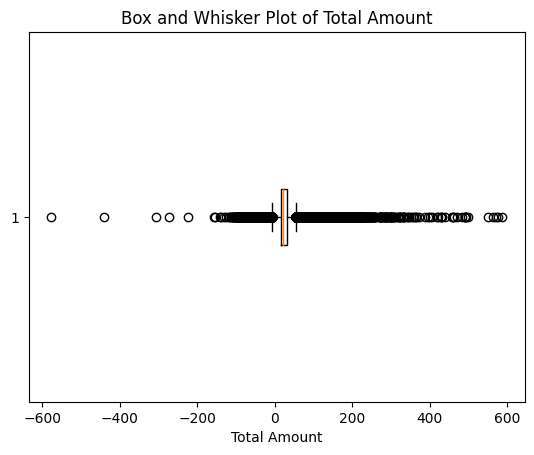

In [8]:
# Identifying the outliers using IQR method. As of now our target variable is total_amount therefore we specifically see
# the outliers in toal_amount attributes as they might affect our regression model.


# Create the box plot
plt.boxplot(Data['total_amount'], vert=False)  # Set vert=False to create a horizontal box plot
plt.xlabel('Total Amount')
plt.title('Box and Whisker Plot of Total Amount')
plt.show()


In [9]:
# Calculate summary statistics
Data['total_amount'].describe()

count    175000.000000
mean         29.633901
std          25.425206
min        -576.750000
25%          16.300000
50%          21.450000
75%          31.800000
max         587.250000
Name: total_amount, dtype: float64

In [10]:
negative_total_amount = Data[Data['total_amount'] < 0]
negative_total_amount.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,1725.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000
passenger_count,1725.0,1.385507,0.782879,1.000000,1.000000,1.000000,2.000000,6.00000
trip_distance,1725.0,3.317235,5.761849,0.000000,0.320000,1.190000,3.060000,83.69000
RatecodeID,1725.0,1.205797,0.681178,1.000000,1.000000,1.000000,1.000000,5.00000
PULocationID,1725.0,132.743768,77.122235,1.000000,63.000000,133.000000,199.000000,264.00000
DOLocationID,1725.0,134.882899,78.767928,1.000000,62.000000,138.000000,205.000000,264.00000
extra,1725.0,-1.371014,1.544966,-7.500000,-2.500000,-1.000000,0.000000,0.00000
tip_amount,1725.0,2.625304,1.831323,0.000079,1.292728,2.618123,3.867927,36.19792
tolls_amount,1725.0,-0.541739,2.142528,-29.300000,0.000000,0.000000,0.000000,0.00000
improvement_surcharge,1725.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000


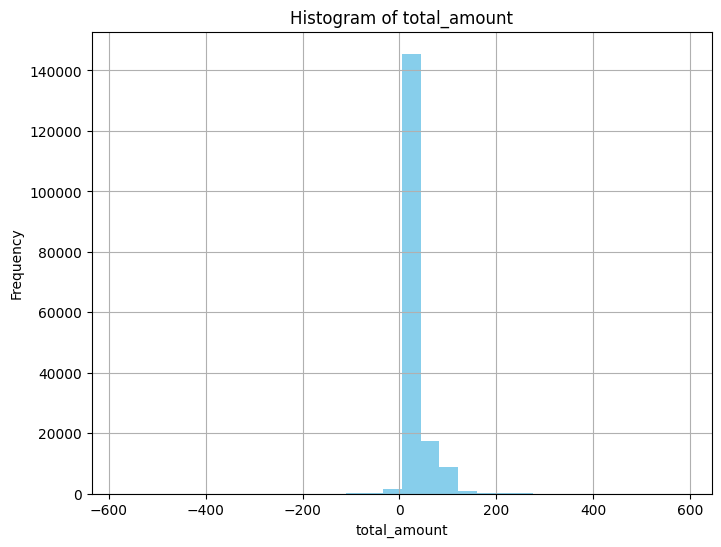

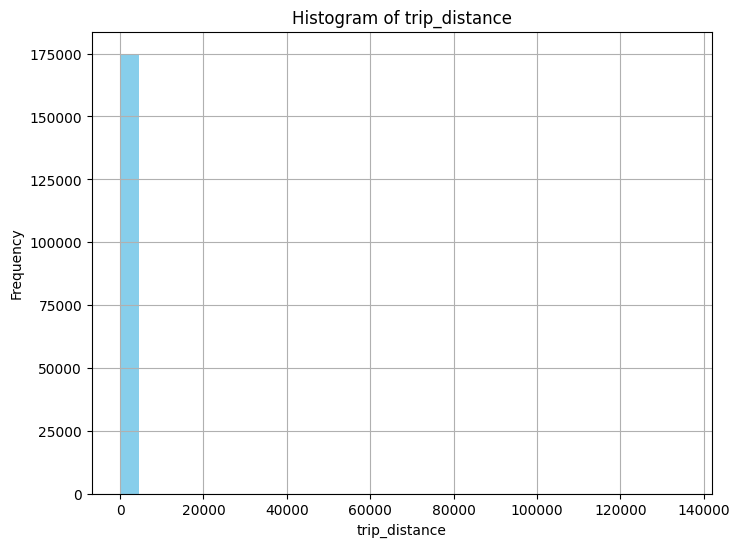

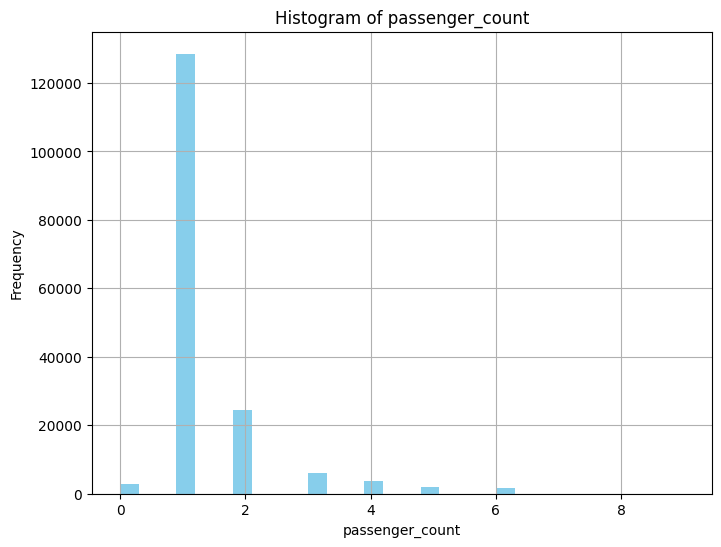

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Selected features for histograms
features = ['total_amount', 'trip_distance', 'passenger_count']

# Plotting histograms for selected features
for feature in features:
    plt.figure(figsize=(8, 6))
    plt.hist(Data[feature], bins=30, color='skyblue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    

In [12]:
Data['trip_distance'].describe()

count    175000.000000
mean          5.145930
std         394.971052
min           0.000000
25%           1.080000
50%           1.840000
75%           3.610000
max      135182.060000
Name: trip_distance, dtype: float64

In [13]:
l = Data[Data['trip_distance'] > 100]
l

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
55147,1,2023-06-29 15:53:29,2023-06-29 15:52:58,1.0,9673.69,1.0,N,107,228,Credit Card,0.00,6.042202,0.00,1.0,9.60,0.0,0.00
59599,0,2023-06-29 23:18:24,2023-06-30 02:56:23,1.0,132.10,1.0,N,92,234,Cash,2.75,3.682359,6.55,1.0,494.00,0.0,1.75
70458,1,2023-06-30 23:03:21,2023-07-01 00:16:10,NaN,20314.00,NaN,NaN,249,84,Wallet,0.00,9.657420,0.00,1.0,42.56,NaN,NaN
85525,1,2023-06-29 05:23:56,2023-06-29 04:33:47,NaN,135182.06,NaN,NaN,133,80,Wallet,0.00,5.948871,0.00,1.0,27.92,NaN,NaN
107988,1,2023-06-29 03:32:14,2023-06-29 04:57:15,NaN,92292.43,NaN,NaN,55,71,Wallet,0.00,4.262185,0.00,1.0,18.00,NaN,NaN
153336,1,2023-06-29 11:58:25,2023-06-29 13:27:50,1.0,104.09,5.0,N,242,30,Cash,0.00,0.380620,19.30,1.0,470.30,0.0,0.00
165589,1,2023-06-29 06:09:30,2023-06-29 08:30:26,2.0,143.35,5.0,N,209,115,Credit Card,0.00,0.951270,6.55,1.0,359.30,0.0,1.75


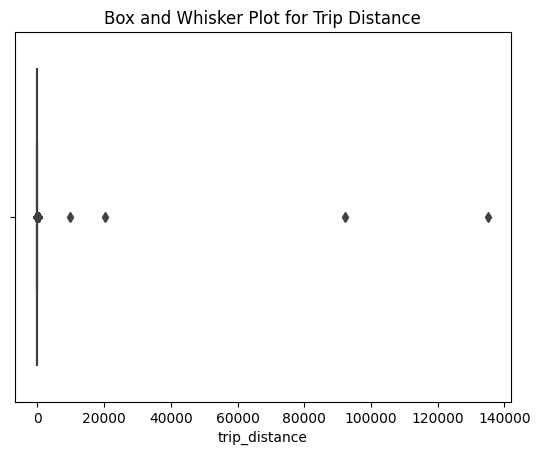

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='trip_distance', data=Data)
plt.title('Box and Whisker Plot for Trip Distance')
plt.show()


# Visualization of Data and understanding importance of features.

In [15]:
# Splitting categorical and numerical features 
categorical_features = Data.select_dtypes(['object']).columns.tolist()
numerical_features = Data.select_dtypes(['int','float']).columns.tolist()

In [16]:
print(categorical_features)
print(numerical_features)

['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'payment_type']
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']


In [17]:
import pandas as pd
import seaborn as sns


# 1. Handle Missing Values
# Replace missing values in numerical features with their median
Data['passenger_count'] = Data['passenger_count'].fillna(Data['passenger_count'].median())
Data['RatecodeID'] = Data['RatecodeID'].fillna(Data['RatecodeID'].median())
Data['congestion_surcharge'] = Data['congestion_surcharge'].fillna(Data['congestion_surcharge'].median())
Data['Airport_fee'] = Data['Airport_fee'].fillna(Data['Airport_fee'].median())


# Replace missing values in categorical features with the mode (most frequent value)
Data['store_and_fwd_flag'] = Data['store_and_fwd_flag'].fillna(Data['store_and_fwd_flag'].mode().iloc[0])

In [18]:
Data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [19]:
# 2. Encode Categorical Variables
# Perform one-hot encoding for categorical variables
encoded_data = pd.get_dummies(Data[['store_and_fwd_flag', 'payment_type']], drop_first=True)

# Concatenate numerical and encoded categorical features
processed_data = pd.concat([Data[numerical_features], encoded_data], axis=1)

In [20]:
# 3. Feature Extraction
# Convert the pickup and dropoff datetime columns to datetime objects
Data['tpep_pickup_datetime'] = pd.to_datetime(Data['tpep_pickup_datetime'])
Data['tpep_dropoff_datetime'] = pd.to_datetime(Data['tpep_dropoff_datetime'])

processed_data['duration'] = (Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']).dt.total_seconds()/60

In [21]:
processed_data.shape

(175000, 19)

In [22]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   VendorID                  175000 non-null  int64  
 1   passenger_count           175000 non-null  float64
 2   trip_distance             175000 non-null  float64
 3   RatecodeID                175000 non-null  float64
 4   PULocationID              175000 non-null  int64  
 5   DOLocationID              175000 non-null  int64  
 6   extra                     175000 non-null  float64
 7   tip_amount                175000 non-null  float64
 8   tolls_amount              175000 non-null  float64
 9   improvement_surcharge     175000 non-null  float64
 10  total_amount              175000 non-null  float64
 11  congestion_surcharge      175000 non-null  float64
 12  Airport_fee               175000 non-null  float64
 13  store_and_fwd_flag_Y      175000 non-null  b

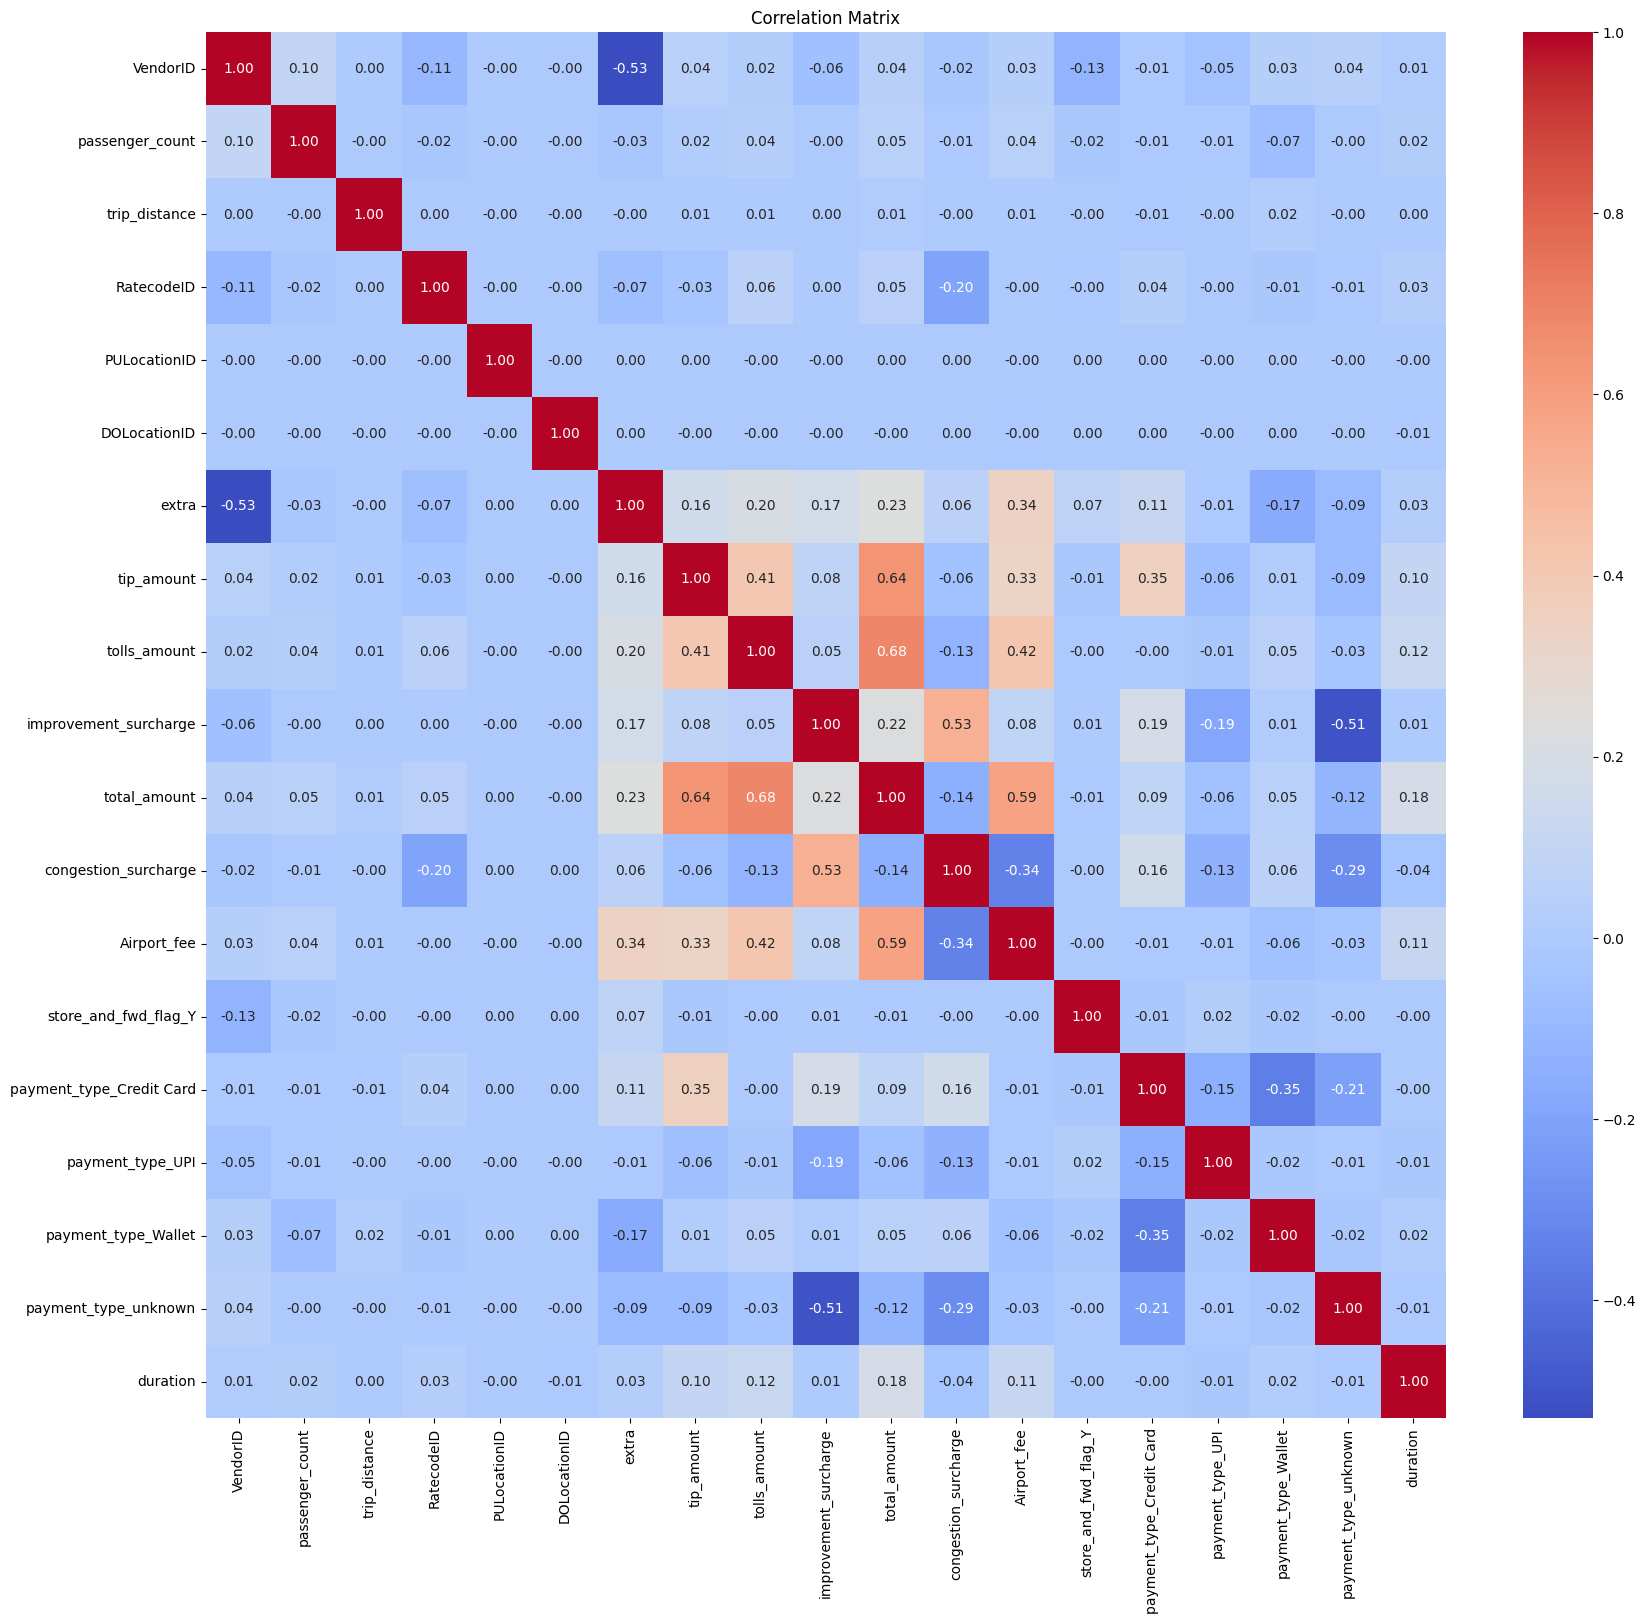

In [23]:


# 4. Create Correlation Matrix
# Compute correlation matrix using Pearson for numerical and Point Biserial for mixed data types
correlation_matrix_numerical = processed_data.corr(method='pearson')

# 5. Visualize the Correlation Matrix
# Generate heatmap using Seaborn
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix_numerical, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show()


# Insights from the Data Visuals
1. The total amount generally paid by the passengers is between 0 to 100.
1. Their are only 7 rows which has more than 100 value of trip distance and out of them 4 are clearly outliers justified by boxplot.
1. Their are 1725 rows with negative total_amount.
1. From the below heatmap we get to know that two features PULocationID & DOLocationID have zero correlation with total amount so we can drop those columns.
1. From the given histogram for passenger_count we can see that the single passenger will board the taxi mostly.



# Training & Test data splitting from the given training data

In [24]:
from sklearn.model_selection import train_test_split

X = Data.drop('total_amount', axis = 1)
y = Data['total_amount']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pipeline implementation for Preprocessing

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

# Implementing Feature engineering
# Function to calculate duration from pickup and dropoff datetime
def calculate_duration(X):
    X['tpep_pickup_datetime'] = pd.to_datetime(X['tpep_pickup_datetime'])
    X['tpep_dropoff_datetime'] = pd.to_datetime(X['tpep_dropoff_datetime'])
    X['duration'] = (X['tpep_dropoff_datetime'] - X['tpep_pickup_datetime']).dt.total_seconds() / 60
    return X[['duration']]

# Define numerical, categorical and datetime features
# numerical_features = ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee']

numerical_features = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'extra', 'tip_amount', 
 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']

categorical_features = ['store_and_fwd_flag', 'payment_type']

datetime_features = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

# Create pipelines for numerical and categorical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

# Create final pipeline for all steps
full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
    ('duration', FunctionTransformer(calculate_duration), datetime_features)
])

# Process the data
X_train = full_pipeline.fit_transform(X_train, y_train)

In [26]:
# This will be done for the test_data
# Passing the test dataset with the pipeline without showing Y_test
X_test = full_pipeline.transform(X_test)

In [27]:
X_train.shape

(140000, 16)

# Implementing PCA to improve models prediction

In [28]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler


# # Apply PCA
# pca = PCA(n_components=10)  # Choose the number of components you want

# # Training PCA with train data
# X_train = pca.fit_transform(X_train)

# # Implementing the training info on test data
# X_test = pca.transform(X_test)


# Model 1. Implementing Linear Regression Model

In [29]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score


# # Initialize the Linear Regression model
# model = LinearRegression()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions using the testing set
# y_pred = model.predict(X_test)

# # Model evaluation
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

# # Get the coefficients (weights)
# coefficients = model.coef_
# intercept = model.intercept_

# print("Coefficients:", coefficients)
# print("Intercept:", intercept)


* The mse is 178.48 using Linear regression and it is much high as compared to Random Forest Regressor.
* The r2 score given by LR model is 0.72. 
* Linear regression coefficients represent the specific impact of each feature on the target variable within a linear model.
* After using PCA with 10 components the r2 score gets reduced to 0.71.

# Model 2. Implementing Random Forest Regressor

In [30]:
# from sklearn.ensemble import RandomForestRegressor


# # Initialize the Random Forest Regressor
# rf = RandomForestRegressor(random_state=42)


# # Train the model
# rf = RandomForestRegressor(random_state=42)
# rf.fit(X_train, y_train)

# # Make predictions
# y_pred = rf.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error:", mse)
# print("R-squared (R2) Score:", r2)

# # Get the coefficients (weights)
# coefficients = model.coef_
# intercept = model.intercept_

# print("Coefficients:", coefficients)
# print("Intercept:", intercept)

* The mse given by RFR model is 28.73 without hyperparameter tunning.
* The r2 score given by this RFR model is 0.95 without hyperpameter tunning.
* Random Forest coefficients indicate how important each feature is for the model's predictive performance.
* After using PCA with 10 components the r2 score gets reduced to 0.86 and mse also gets increased.

# Model 3. Implementing LightGBM model

In [31]:
# import lightgbm as lgb

# # Create LightGBM datasets
# train_data_lgb = lgb.Dataset(X_train, label=y_train)
# test_data_lgb = lgb.Dataset(X_test, label=y_test)

# # Set default parameters
# params = {
#     'objective': 'regression',
#     'metric': 'rmse'  # RMSE is default for regression
# }

# # Train the model
# model_lgb = lgb.train(params, train_data_lgb, valid_sets=[test_data_lgb])

# # Make predictions on the test set
# y_pred = model_lgb.predict(X_test)

# # Evaluate the model
# r2 = r2_score(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f"R2 Score: {r2:.4f}")
# print(f"Mean Squared Error: {mse:.4f}")


* The r2 score is 0.9371 by using default perameters in LightGBM.
* The mse is 40.929 by using default perameters in LightGBM.
* After using PCA the r2_score gets reduced to 0.845 and mse rise to 100.2877

# Model 4. Implementing XGboost

In [32]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [ 0.8, 0.9, 1],
    'colsample_bytree': [ 0.8, 0.9, 1]
}

# # Create the XGBoost regressor
# xgb = XGBRegressor()

# # Create GridSearchCV
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='r2', cv=5, verbose=2, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_


# Hyperparameter tunning result
Got grid_search.best_params_ as :
*  'colsample_bytree': 0.9,
*  'learning_rate': 0.1,
*  'max_depth': 6,
*  'min_child_weight': 3,
*  'subsample': 1

In [33]:
best_params = {'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'subsample': 1}

In [34]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV


# # Create an XGBoost regressor
# xgb_regressor = xgb.XGBRegressor(**best_params)

# # Fit the model on the training data
# xgb_regressor.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = xgb_regressor.predict(X_test)

# # Evaluate the model
# from sklearn.metrics import r2_score, mean_squared_error

# # R2 score
# r2 = r2_score(y_test, y_pred)
# print(f"R2 score: {r2:.4f}")

# # Mean Squared Error
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.4f}")


* Getting 0.9562 r2_score by default parameters in XGboost.
* mse of 28.50 by default parameters in XGboost.
* In this also PCA reduced the performance of the model.
* After tunning the hyperparameters of XGboost the r2 score gets improved to 0.942 from 0.941.

# Model 5. Implementing Gradient Boosting

In [35]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import r2_score

# # Initialize the Gradient Boosting Regressor
# gradient_boosting = GradientBoostingRegressor()

# # Fit the model
# gradient_boosting.fit(X_train, y_train)

# # Make predictions
# y_pred = gradient_boosting.predict(X_test)

# # R2 score
# r2 = r2_score(y_test, y_pred)
# print(f"R2 score: {r2:.4f}")

# # Mean Squared Error
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.4f}")


* r2_score of 0.9419 by default parameters in Gradient boost.
* mse of 37.8391 by default parameters in Gradient boost.
* pca reduced this model performance.

# Comparison between all the models.

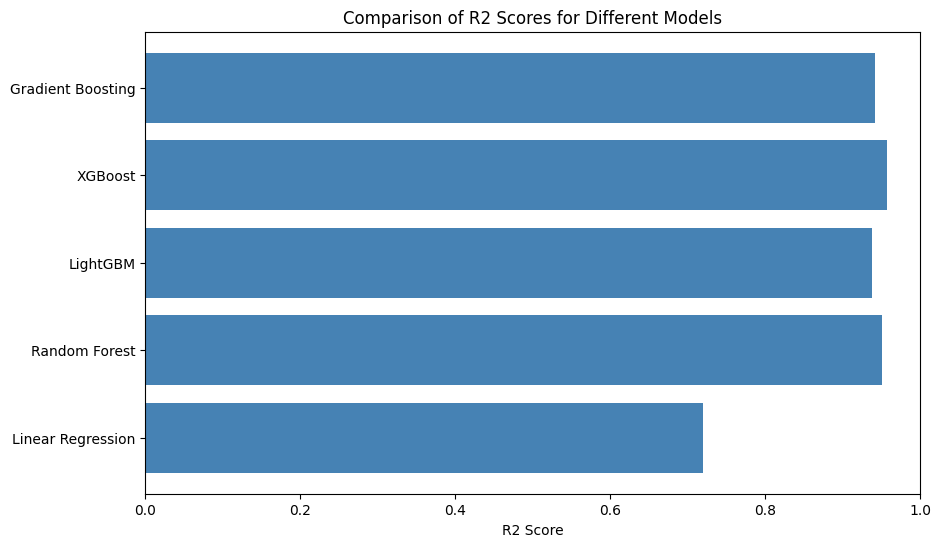

In [36]:
import matplotlib.pyplot as plt

# List of models and their corresponding R2 scores
models = ['Linear Regression', 'Random Forest','LightGBM','XGBoost', 'Gradient Boosting']
r2_scores = [0.72, 0.95, 0.9371 ,0.9562, 0.9419]

# Plotting the R2 scores
plt.figure(figsize=(10, 6))
plt.barh(models, r2_scores, color='steelblue')
plt.xlabel('R2 Score')
plt.title('Comparison of R2 Scores for Different Models')
plt.xlim(0, 1)  # Set the limit of the x-axis from 0 to 1 (R2 score range)
plt.show()


# Making Final model and training it with the whole dataset

In [37]:
Data_features = Data.drop('total_amount', axis = 1)
Data_label_vector = Data['total_amount']

In [38]:
Data_features = full_pipeline.transform(Data_features)

In [39]:
import xgboost as xgb


# Create an XGBoost regressor
xgb_regressor_final = xgb.XGBRegressor(**best_params)

# Fit the model on the whole given dataset i.e. Data
xgb_regressor_final.fit(Data_features, Data_label_vector)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Evaluation on Test Dataset

In [40]:
test_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,1.0,6.067612,0.0,1.0,2.5,0.0
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,2.5,6.191269,0.0,1.0,2.5,0.0
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,2.5,3.983872,0.0,1.0,2.5,0.0
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,3.5,6.839341,0.0,1.0,2.5,0.0
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,0.0,1.468943,0.0,1.0,0.0,0.0


In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               50000 non-null  int64  
 1   tpep_pickup_datetime   50000 non-null  object 
 2   tpep_dropoff_datetime  50000 non-null  object 
 3   passenger_count        48221 non-null  float64
 4   trip_distance          50000 non-null  float64
 5   RatecodeID             48221 non-null  float64
 6   store_and_fwd_flag     48221 non-null  object 
 7   PULocationID           50000 non-null  int64  
 8   DOLocationID           50000 non-null  int64  
 9   payment_type           50000 non-null  object 
 10  extra                  50000 non-null  float64
 11  tip_amount             50000 non-null  float64
 12  tolls_amount           50000 non-null  float64
 13  improvement_surcharge  50000 non-null  float64
 14  congestion_surcharge   48221 non-null  float64
 15  Ai

In [42]:
# test_data.isnull().sum()

In [43]:
# Passing the test dataset with the pipeline without showing Y_test
processed_data = full_pipeline.transform(test_data)

In [44]:
# Model 1. Linear Regression
# output = model.predict(processed_data)



In [45]:
#Model 2. Random Forest Regressor
# output = rf.predict(processed_data)

In [46]:
# Model 3. LightGBM
# output = model_lgb.predict(processed_data)

In [47]:
# Model 4. XGBoost
# output = xgb_regressor.predict(processed_data)

In [48]:
# Model 5. Gradient Boosting
# output = gradient_boosting.predict(processed_data)


In [49]:
# Final model XGboost Fitted on whole dataset with best parameters
output = xgb_regressor_final.predict(processed_data)

# Final submission 

In [50]:
output = pd.DataFrame({'ID': np.arange(1,50001), 'total_amount': output})
print(output)
output.to_csv("submission.csv", index=False)

          ID  total_amount
0          1     33.872433
1          2     24.964161
2          3     16.275692
3          4     14.941721
4          5     24.774433
...      ...           ...
49995  49996     15.204608
49996  49997     28.011806
49997  49998     20.732632
49998  49999     36.015846
49999  50000     17.322836

[50000 rows x 2 columns]
